# MLP model with new data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from livemodel_mlp import Preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, ReLU, Dropout, Softmax
from tensorflow.math import confusion_matrix

## Load Data

In [2]:
root_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

file_names = ['asdf-dohun-0621-1530.csv', 
             'asdf-dohun-0621-1541.csv', 
             'asdf-honey-0621-1550.csv']

file_paths = [os.path.join(root_path, os.path.join('dataset', f)) for f in file_names]

In [3]:
x_names = ['L%d%c' % (i, c) for i in range(21) for c in ['x', 'y', 'z']]
y_names = ['a', 's', 'd', 'f']

col_names = x_names + y_names

dfs = [pd.read_csv(f, names=col_names) for f in file_paths]
df = pd.concat(dfs, axis=0)
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
df

,L0x,L0y,L0z,L1x,L1y,L1z,L2x,L2y,L2z,L3x,...,L19x,L19y,L19z,L20x,L20y,L20z,a,s,d,f
0,0.555741,0.200676,-0.000055,0.490484,0.237294,-0.024068,0.452668,0.298484,-0.064471,0.437984,...,0.607877,0.448763,-0.201303,0.597357,0.486077,-0.202801,0,0,0,1
1,0.562396,0.214681,-0.000066,0.497366,0.244111,-0.021054,0.459037,0.302610,-0.057921,0.441655,...,0.599877,0.467566,-0.174591,0.587214,0.500556,-0.168457,0,1,0,0
2,0.566253,0.210346,-0.000063,0.500220,0.240800,-0.019462,0.459498,0.296979,-0.061539,0.438800,...,0.590953,0.469179,-0.181865,0.576559,0.505174,-0.181547,1,0,0,0
3,0.285281,0.752872,-0.000052,0.372674,0.706251,-0.030979,0.418578,0.624886,-0.079446,0.438249,...,0.187995,0.383598,-0.171888,0.209205,0.335026,-0.163791,0,0,1,0
4,0.662824,0.095909,-0.000088,0.601700,0.130446,-0.025103,0.562443,0.194357,-0.063629,0.541697,...,0.725242,0.342652,-0.149671,0.724568,0.383640,-0.150064,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41392,0.269808,0.766912,-0.000068,0.360976,0.730485,-0.036869,0.425738,0.670177,-0.083443,0.465932,...,0.191618,0.369645,-0.161350,0.202200,0.308111,-0.164672,0,0,0,0
41393,0.293335,0.764110,-0.000045,0.385281,0.732939,-0.025596,0.445328,0.671179,-0.066866,0.483620,...,0.232021,0.388088,-0.135896,0.242558,0.335317,-0.139232,0,0,0,0
41394,0.285618,0.751764,-0.000039,0.372403,0.707180,-0.034424,0.422836,0.628457,-0.080719,0.448418,...,0.188938,0.383927,-0.173966,0.207723,0.331581,-0.167933,0,0,0,0
41395,0.558528,0.201199,-0.000069,0.492204,0.241112,-0.022172,0.452528,0.304544,-0.058564,0.435648,...,0.616683,0.448690,-0.179030,0.612625,0.485263,-0.181036,0,1,0,0


## Preprocessing

In [5]:
# add 'none' label
df['none'] = (df.a + df.s + df.d + df.f == 0).astype(int)

y_names.append('none')
col_names.append('none')

In [6]:
# x-y split
x_df, y_df = df[x_names], df[y_names]

print('x_df:', x_df.shape)
print('y_df:', y_df.shape)

x_df: (41397, 63)
y_df: (41397, 5)


In [7]:
# train-test split
train_test_ratio = 0.9
train_num = int(len(df) * train_test_ratio)

x_train = x_df[:train_num].values
y_train = y_df[:train_num].values

x_test  = x_df[train_num:].values
y_test  = y_df[train_num:].values

print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

x_train: (37257, 63)
y_train: (37257, 5)
x_test: (4140, 63)
y_test: (4140, 5)


In [8]:
# hands data preprocessor
preprocessor = Preprocessing(gamma_smoothing=True,
                             local_minmax=True)

In [9]:
results = []
for x in (x_train, x_test):
    result = []
    for row in x:
        res = preprocessor.process(row)
        result.append(res)
    results.append(result)
    preprocessor.reset()

x_train = np.array(results[0])
x_test  = np.array(results[1])

## Model

In [10]:
'''
Original code:
    https://gist.github.com/wassname/ce364fddfc8a025bfab4348cf5de852d
'''

import tensorflow as tf
from tensorflow.keras import backend as K

def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        y_true = tf.cast(y_true, dtype=tf.float32)
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [11]:
model = Sequential([
    InputLayer(input_shape=(63,)),

    Dense(64, kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),

    Dense(32, kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),

    Dense(5, kernel_initializer='he_normal'),
    Softmax()
])

In [12]:
weights = y_train.sum() / y_train.sum(axis=0)
# weights = weights / weights.max()
weights

array([10.2777931 ,  8.0174306 ,  8.11345819,  9.50676193,  1.81972257])

In [13]:
loss = weighted_categorical_crossentropy(weights)

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [14]:
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

Epoch 1/50
932/932 [==============================] - 2s 2ms/step - loss: 8.5237 - accuracy: 0.2535 - val_loss: 7.5956 - val_accuracy: 0.4206
Epoch 2/50
932/932 [==============================] - 1s 2ms/step - loss: 7.5750 - accuracy: 0.3161 - val_loss: 7.2159 - val_accuracy: 0.4310
Epoch 3/50
932/932 [==============================] - 1s 1ms/step - loss: 7.3183 - accuracy: 0.3333 - val_loss: 7.0087 - val_accuracy: 0.3898
Epoch 4/50
932/932 [==============================] - 1s 2ms/step - loss: 7.2036 - accuracy: 0.3425 - val_loss: 7.0114 - val_accuracy: 0.3574
Epoch 5/50
932/932 [==============================] - 1s 2ms/step - loss: 7.1079 - accuracy: 0.3414 - val_loss: 7.0008 - val_accuracy: 0.2999
Epoch 6/50
  1/932 [..............................] - ETA: 1s - loss: 8.4000 - accuracy: 0.3438

KeyboardInterrupt: 

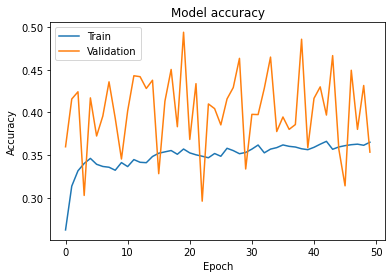

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

In [16]:
model.evaluate(x_test, y_test, verbose=2)

130/130 - 0s - loss: 9.5366 - accuracy: 0.2899


[9.536551475524902, 0.28985506296157837]

In [18]:
predict = model.predict(x_test)

In [34]:
conf_predict = []
conf_y_test = []

for i in range(len(predict)):
    conf_predict.append(predict[i].argmax())
    conf_y_test.append(y_test[i].argmax())

conf = confusion_matrix(conf_y_test, conf_predict).numpy()

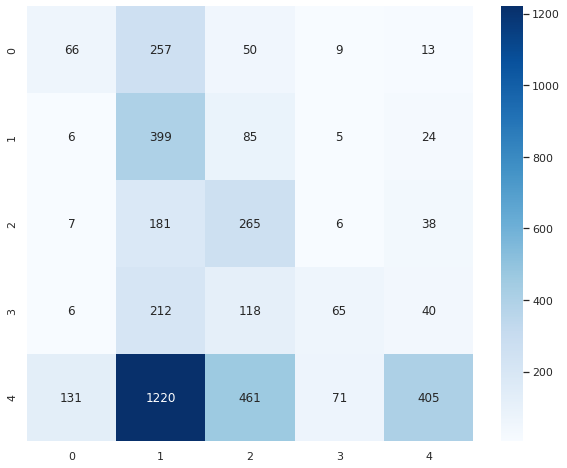

In [40]:
sns.set(rc={'figure.figsize':(10, 8)})

labels = [f'{val:d}' for val in conf.flatten()]
labels = np.array(labels).reshape(5, 5)

sns.heatmap(conf, annot=labels, fmt='', cmap='Blues')
plt.show()